In [1]:
#make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../")
import copy
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7fe56f282e10>


In [2]:
base_input = '../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['A']
['B']
['C']
-----
{'A'}
{'A'}
set()
-----
{'A'}
{'B'}
{'A'}
False
Allowed edges: 
('A', 'B')
Connected Nodes:  ['A', 'B']
Connected Edges:  [('A', 'B')]
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', 'C')
New node added--1
['A', 'B']
{('A', 'B'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3]
-----
{'A'}
{'C'}
{'A'}
False
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Connected Nodes:  ['A', 'C']
Connected Edges:  [('A', 'C')]
Allowed edges: 
('B', 'C')
New node added--1
['A', 'C']
{('A', 'B'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3, 4]
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', '

In [3]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [0.2850, 0.2850, 0.2850, 1.5923, 1.5923, 1.5923] #Max yield Simruntime = 10sec
new_kon = [0.0199, 0.0198, 0.0209, 1.6899, 1.6899, 1.6903]   #Poor yield Simruntime = 1sec

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20000.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20000.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40000.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20000.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20000.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40000.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20000.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20000.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40000.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40000.], dtype=torch.

In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)
runtime = 1000
sim = VecSim(vec_rn, runtime, device='cpu')
y = sim.simulate()

Using CPU
Current time:  tensor(994.6089, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time:  tensor(1002.1065, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.


Text(0.5, 1.0, 'runtime: 1000 seconds')

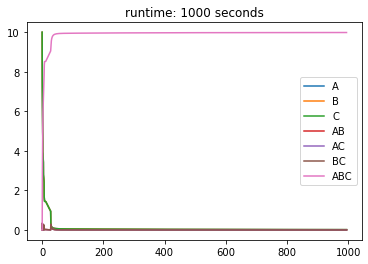

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
nodes_list = ['A','B','C','AB','BC','AC','ABC']
sim.plot_observable(nodes_list, ax=ax)
ax.set_title("runtime: " + str(runtime) + " seconds")

In [7]:
print(vec_rn.copies_vec)
print(vec_rn.kon)

tensor([1.3042e-02, 1.3034e-02, 1.3034e-02, 1.7590e-04, 1.7512e-04, 1.8365e-04,
        9.9866e+00], dtype=torch.float64, grad_fn=<MaxBackward2>)
Parameter containing:
tensor([0.0199, 0.0198, 0.0209, 1.6899, 1.6899, 1.6903], dtype=torch.float64,
       requires_grad=True)
